## First Attempt

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# 1. Caricamento dei dati scaricati manualmente
path_dati = "/Users/tommaso/Desktop/GT_Data/Official"
nomi_gruppi = {
    "Gruppo1": "Termini_Diretti",
    "Gruppo2": "Alimentari",
    "Gruppo3": "Energia",
    "Gruppo4": "Abitazione",
    "Gruppo5": "Trasporti",
    "Gruppo6": "Politiche_Economiche",
    "Gruppo7": "Aspettative_Consumatori",
    "Gruppo8": "Sanita",
    "Gruppo9": "Ricreazione"
}

# Funzione per caricare i dati GT
def carica_dati_gt(path, nomi_file):
    dati_gruppi = {}
    
    for nome_file, nome_gruppo in nomi_gruppi.items():
        file_path = os.path.join(path, f"{nome_file}.csv")
        
        try:
            # Salta le prime due righe (header = riga 3 del file)
            df = pd.read_csv(file_path, skiprows=2)
            
            # Normalizza nomi colonne
            df.columns = [col.strip().lower() for col in df.columns]
            
            # Controlla presenza colonna 'mese'
            if 'mese' not in df.columns:
                raise ValueError(f"Colonna 'mese' non trovata in {nome_file}")
            
            # Imposta indice e converti in datetime
            df.set_index('mese', inplace=True)
            df.index = pd.to_datetime(df.index, format="%Y-%m")
            
            dati_gruppi[nome_gruppo] = df
            print(f"✓ Dati caricati con successo per {nome_gruppo}")
        
        except Exception as e:
            print(f"✗ Errore nel caricamento di {nome_file}: {e}")
    
    return dati_gruppi

# Carica i dati
dati_gruppi = carica_dati_gt(path_dati, nomi_gruppi)




✓ Dati caricati con successo per Termini_Diretti
✓ Dati caricati con successo per Alimentari
✓ Dati caricati con successo per Energia
✓ Dati caricati con successo per Abitazione
✓ Dati caricati con successo per Trasporti
✓ Dati caricati con successo per Politiche_Economiche
✓ Dati caricati con successo per Aspettative_Consumatori
✓ Dati caricati con successo per Sanita
✓ Dati caricati con successo per Ricreazione


In [2]:
# 2. Allineamento delle scale usando "inflazione" come termine comune
def allinea_scale(dati_gruppi, query_riferimento="inflazione: (Italia)"):
    # Calcola la media del termine di riferimento in ogni gruppo
    medie_riferimento = {}
    for gruppo, dati in dati_gruppi.items():
        cols_lower = [col.lower() for col in dati.columns]
        if query_riferimento.lower() in cols_lower:
            idx = cols_lower.index(query_riferimento.lower())
            col_name = dati.columns[idx]  # Nome originale con maiuscole/minuscole
            medie_riferimento[gruppo] = dati[col_name].mean()
    
    # Identifico il gruppo di base
    gruppo_base = list(medie_riferimento.keys())[0]
    fattore_base = medie_riferimento[gruppo_base]
    
    # Allinea tutti i gruppi alla scala del gruppo base
    dati_allineati = {}
    for gruppo, dati in dati_gruppi.items():
        if gruppo in medie_riferimento:
            fattore_scala = fattore_base / medie_riferimento[gruppo]
            dati_allineati[gruppo] = dati.copy()
            
            # Scala tutte le colonne tranne eventuali colonne non numeriche
            for col in dati.columns:
                if pd.api.types.is_numeric_dtype(dati[col]):
                    dati_allineati[gruppo][col] = dati[col] * fattore_scala
    
    return dati_allineati

# Allinea i dati
dati_allineati = allinea_scale(dati_gruppi)


In [3]:
# 3. Gestione dei periodi temporali diversi
# In caso i file abbiano periodi diversi, dobbiamo trovare il periodo comune

def trova_periodo_comune(dati_gruppi):
    date_inizio = []
    date_fine = []
    
    for gruppo, df in dati_gruppi.items():
        date_inizio.append(df.index.min())
        date_fine.append(df.index.max())
    
    # Il periodo comune va dalla data di inizio più recente alla data di fine più antica
    inizio_comune = max(date_inizio)
    fine_comune = min(date_fine)
    
    print(f"Periodo comune identificato: {inizio_comune} a {fine_comune}")
    
    # Verifica che il periodo comune sia valido
    if inizio_comune >= fine_comune:
        print("⚠️ Attenzione: Non c'è un periodo comune tra tutti i gruppi!")
        return None, None
    
    return inizio_comune, fine_comune

inizio_comune, fine_comune = trova_periodo_comune(dati_allineati)


Periodo comune identificato: 2004-01-01 00:00:00 a 2024-12-01 00:00:00


In [4]:
# 4. Filtra i dati per il periodo comune e combina in un unico dataset
def combina_dati(dati_allineati, inizio, fine, query_riferimento="inflazione: (Italia)"):
    if inizio is None or fine is None:
        print("Impossibile combinare i dati: periodo comune non valido")
        return None
    
    # Inizializza il dataframe combinato
    df_combinato = pd.DataFrame(index=pd.date_range(start=inizio, end=fine, freq='MS'))
    print(f"DataFrame combinato inizializzato con {len(df_combinato)} righe")
    
    for gruppo, df in dati_allineati.items():
        # Filtra per il periodo comune
        df_periodo = df[(df.index >= inizio) & (df.index <= fine)]
        print(f"Gruppo '{gruppo}' filtrato: {df_periodo.shape[0]} righe")
        
        # Rinomina le colonne per identificare il gruppo
        for col in df_periodo.columns:
            # Evita duplicati della query di riferimento
            if col.lower() != query_riferimento.lower() or gruppo == list(dati_allineati.keys())[0]:
                nome_colonna = f"{gruppo}_{col}"
                # Assicurati che l'indice corrisponda
                if df_periodo.index.equals(df_combinato.index):
                    df_combinato[nome_colonna] = df_periodo[col]
                else:
                    # Ricampiona se necessario (questo dipende dalla frequenza dei tuoi dati)
                    df_temp = df_periodo.reindex(df_combinato.index, method='nearest')
                    df_combinato[nome_colonna] = df_temp[col]
                print(f"Colonna aggiunta: {nome_colonna}")
    
    print(f"Totale colonne nel DataFrame combinato: {df_combinato.shape[1]}")
    return df_combinato

# Combina i dati
df_gt_combinato = combina_dati(dati_allineati, inizio_comune, fine_comune)


DataFrame combinato inizializzato con 252 righe
Gruppo 'Termini_Diretti' filtrato: 252 righe
Colonna aggiunta: Termini_Diretti_inflazione: (italia)
Colonna aggiunta: Termini_Diretti_indice dei prezzi al consumo: (italia)
Colonna aggiunta: Termini_Diretti_carrello della spesa: (italia)
Colonna aggiunta: Termini_Diretti_costo della vita: (italia)
Colonna aggiunta: Termini_Diretti_determinazione dei prezzi: (italia)
Gruppo 'Alimentari' filtrato: 252 righe
Colonna aggiunta: Alimentari_prezzo pane: (italia)
Colonna aggiunta: Alimentari_prezzo latte: (italia)
Colonna aggiunta: Alimentari_prezzo pasta: (italia)
Colonna aggiunta: Alimentari_prezzo olio: (italia)
Gruppo 'Energia' filtrato: 252 righe
Colonna aggiunta: Energia_prezzo benzina: (italia)
Colonna aggiunta: Energia_prezzo diesel: (italia)
Colonna aggiunta: Energia_bolletta luce: (italia)
Colonna aggiunta: Energia_bolletta gas: (italia)
Gruppo 'Abitazione' filtrato: 252 righe
Colonna aggiunta: Abitazione_affitto casa: (italia)
Colonna 

In [5]:
# 4bis. Pulizia dei valori '< 1' da Google Trends
def sostituisci_valori_meno_di_1(df):
    df_clean = df.copy()
    
    print("== Log sostituzioni '< 1' per colonna ==")
    for col in df_clean.columns:
        count = df_clean[col].astype(str).str.count("< 1").sum()
        if count > 0:
            print(f"Colonna '{col}': {int(count)} valori '< 1' sostituiti con 0.5")
        
        # Sostituisci '< 1' con 0.5
        df_clean[col] = df_clean[col].replace("< 1", 0.5)
        df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')  # converti in float

    return df_clean

def check_per_valori_testuali(df):
    for col in df.columns:
        if df[col].dtype == 'object':
            print(f"⚠️ La colonna '{col}' contiene ancora stringhe!")
        elif df[col].isnull().any():
            print(f"⚠️ La colonna '{col}' contiene NaN dopo la conversione!")

# Applica la pulizia
df_gt_combinato_clean = sostituisci_valori_meno_di_1(df_gt_combinato)

# Verifica integrità
check_per_valori_testuali(df_gt_combinato_clean)


== Log sostituzioni '< 1' per colonna ==
Colonna 'Energia_bolletta luce: (italia)': 27 valori '< 1' sostituiti con 0.5
Colonna 'Energia_bolletta gas: (italia)': 2 valori '< 1' sostituiti con 0.5
Colonna 'Abitazione_bolletta acqua: (italia)': 76 valori '< 1' sostituiti con 0.5
Colonna 'Abitazione_costo mutuo: (italia)': 43 valori '< 1' sostituiti con 0.5
Colonna 'Politiche_Economiche_quantitative easing: (italia)': 5 valori '< 1' sostituiti con 0.5
Colonna 'Politiche_Economiche_tasso bce: (italia)': 1 valori '< 1' sostituiti con 0.5
Colonna 'Ricreazione_biglietto cinema: (italia)': 11 valori '< 1' sostituiti con 0.5


In [7]:
# 5. Standardizzazione delle serie
def standardizza_serie(df):
    df_std = df.copy()
    for col in df.columns:
        if pd.api.types.is_numeric_dtype(df[col]):
            media = df[col].mean()
            std = df[col].std()
            if std != 0:
                df_std[col] = (df[col] - media) / std
                print(f"Standardizzata colonna: {col}")
            else:
                print(f"[⚠️] Colonna con deviazione standard nulla: {col} – lasciata invariata")
    return df_std

df_gt_std = standardizza_serie(df_gt_combinato_clean)


Standardizzata colonna: Termini_Diretti_inflazione: (italia)
Standardizzata colonna: Termini_Diretti_indice dei prezzi al consumo: (italia)
Standardizzata colonna: Termini_Diretti_carrello della spesa: (italia)
Standardizzata colonna: Termini_Diretti_costo della vita: (italia)
Standardizzata colonna: Termini_Diretti_determinazione dei prezzi: (italia)
Standardizzata colonna: Alimentari_prezzo pane: (italia)
Standardizzata colonna: Alimentari_prezzo latte: (italia)
Standardizzata colonna: Alimentari_prezzo pasta: (italia)
Standardizzata colonna: Alimentari_prezzo olio: (italia)
Standardizzata colonna: Energia_prezzo benzina: (italia)
Standardizzata colonna: Energia_prezzo diesel: (italia)
Standardizzata colonna: Energia_bolletta luce: (italia)
Standardizzata colonna: Energia_bolletta gas: (italia)
Standardizzata colonna: Abitazione_affitto casa: (italia)
Standardizzata colonna: Abitazione_bolletta acqua: (italia)
Standardizzata colonna: Abitazione_spese condominiali: (italia)
Standardiz

In [8]:
# 6. Creazione degli indici PCA per gruppo
# Dobbiamo organizzare le colonne per gruppo (già fatto dal prefisso nel nome colonna)

def crea_indici_pca_per_gruppo(df_std, nomi_gruppi):
    indici_pca = pd.DataFrame(index=df_std.index)
    
    for nome_gruppo in nomi_gruppi.values():
        # Filtra colonne di questo gruppo
        colonne_gruppo = [col for col in df_std.columns if col.startswith(f"{nome_gruppo}_")]
        
        if len(colonne_gruppo) > 1:  # PCA richiede almeno 2 variabili
            # Applica PCA
            pca = PCA(n_components=1)
            componente = pca.fit_transform(df_std[colonne_gruppo])
            
            # Salva il primo componente principale come indice del gruppo
            indici_pca[f'indice_{nome_gruppo}'] = componente.flatten()
            
            # Stampa la varianza spiegata
            print(f"Gruppo {nome_gruppo}: {pca.explained_variance_ratio_[0]:.2%} della varianza spiegata")
            
            # Stampa i loadings (pesi) per interpretazione
            print("Loadings:")
            for i, col in enumerate(colonne_gruppo):
                print(f"  {col}: {pca.components_[0][i]:.4f}")
        
        elif len(colonne_gruppo) == 1:
            # Se c'è una sola colonna, usala direttamente
            indici_pca[f'indice_{nome_gruppo}'] = df_std[colonne_gruppo[0]]
            print(f"Gruppo {nome_gruppo}: una sola colonna disponibile, usata direttamente")
    
    return indici_pca

# Crea indici per ogni gruppo
indici_pca_gruppi = crea_indici_pca_per_gruppo(df_gt_std, nomi_gruppi)



Gruppo Termini_Diretti: 45.77% della varianza spiegata
Loadings:
  Termini_Diretti_inflazione: (italia): 0.5436
  Termini_Diretti_indice dei prezzi al consumo: (italia): -0.3361
  Termini_Diretti_carrello della spesa: (italia): 0.4414
  Termini_Diretti_costo della vita: (italia): 0.3658
  Termini_Diretti_determinazione dei prezzi: (italia): 0.5128
Gruppo Alimentari: 89.00% della varianza spiegata
Loadings:
  Alimentari_prezzo pane: (italia): 0.4856
  Alimentari_prezzo latte: (italia): 0.4973
  Alimentari_prezzo pasta: (italia): 0.5154
  Alimentari_prezzo olio: (italia): 0.5012
Gruppo Energia: 77.70% della varianza spiegata
Loadings:
  Energia_prezzo benzina: (italia): 0.4038
  Energia_prezzo diesel: (italia): 0.5365
  Energia_bolletta luce: (italia): 0.5303
  Energia_bolletta gas: (italia): 0.5176
Gruppo Abitazione: 59.49% della varianza spiegata
Loadings:
  Abitazione_affitto casa: (italia): 0.5613
  Abitazione_bolletta acqua: (italia): 0.5955
  Abitazione_spese condominiali: (italia)

Indice globale: 71.35% della varianza spiegata
✅ Nessun NaN rilevato nel DataFrame finale.


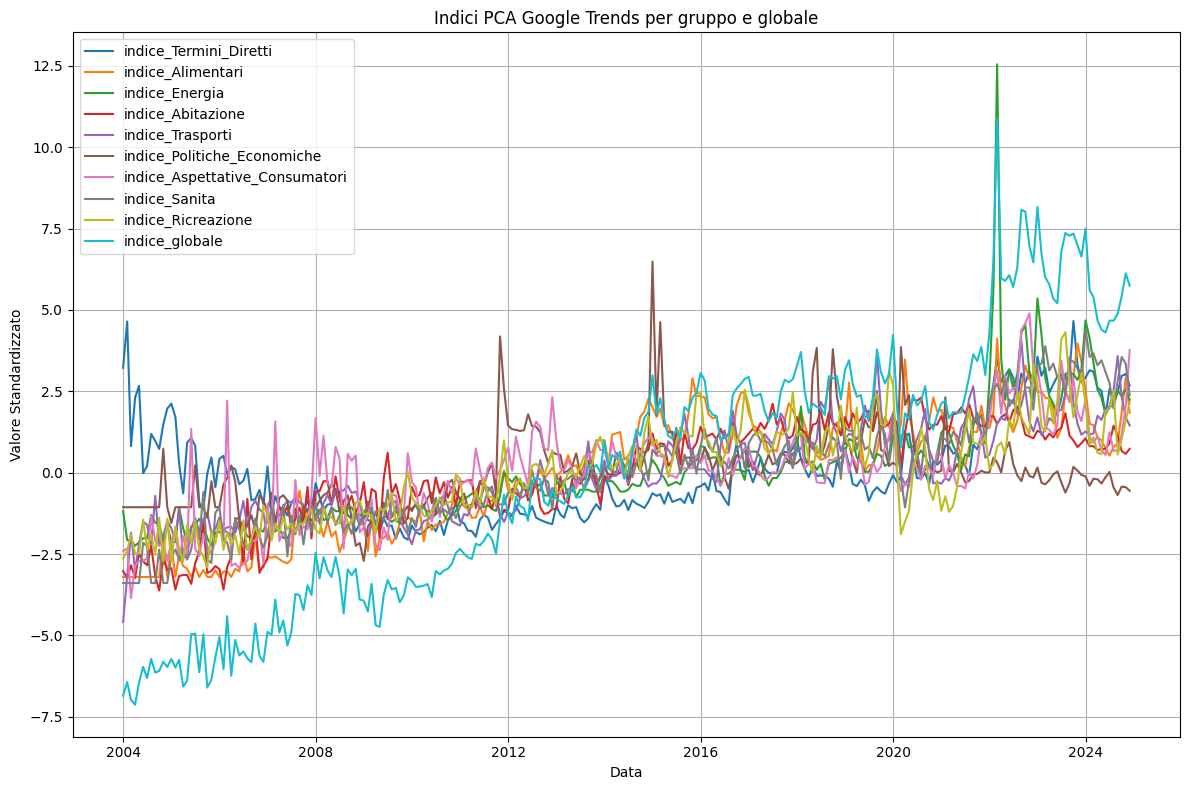

Indici salvati con successo in 'indici_google_trends.csv'


In [9]:
# 7. Creazione dell'indice globale
pca_globale = PCA(n_components=1)
indice_globale = pca_globale.fit_transform(indici_pca_gruppi)

# Aggiungi indice al dataframe
indici_pca_gruppi['indice_globale'] = indice_globale

# Log informativo
print(f"Indice globale: {pca_globale.explained_variance_ratio_[0]:.2%} della varianza spiegata")

# Verifica NaN
if indici_pca_gruppi.isnull().values.any():
    print("[⚠️] Attenzione: il DataFrame finale contiene NaN!")
else:
    print("✅ Nessun NaN rilevato nel DataFrame finale.")

# Visualizza gli indici
plt.figure(figsize=(12, 8))
for col in indici_pca_gruppi.columns:
    plt.plot(indici_pca_gruppi.index, indici_pca_gruppi[col], label=col)
plt.legend()
plt.title('Indici PCA Google Trends per gruppo e globale')
plt.xlabel('Data')
plt.ylabel('Valore Standardizzato')
plt.grid(True)
plt.tight_layout()
plt.show()

# 8. Salva gli indici
indici_pca_gruppi.to_csv('/Users/tommaso/Desktop/GT_Data/PCA/indici_google_trends.csv')
print("Indici salvati con successo in 'indici_google_trends.csv'")


/var/folders/3m/15k2tqw90_s76rn9_8yw2p3r0000gn/T/ipykernel_44803/4177133108.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=varianza, y=gruppi, palette="viridis")


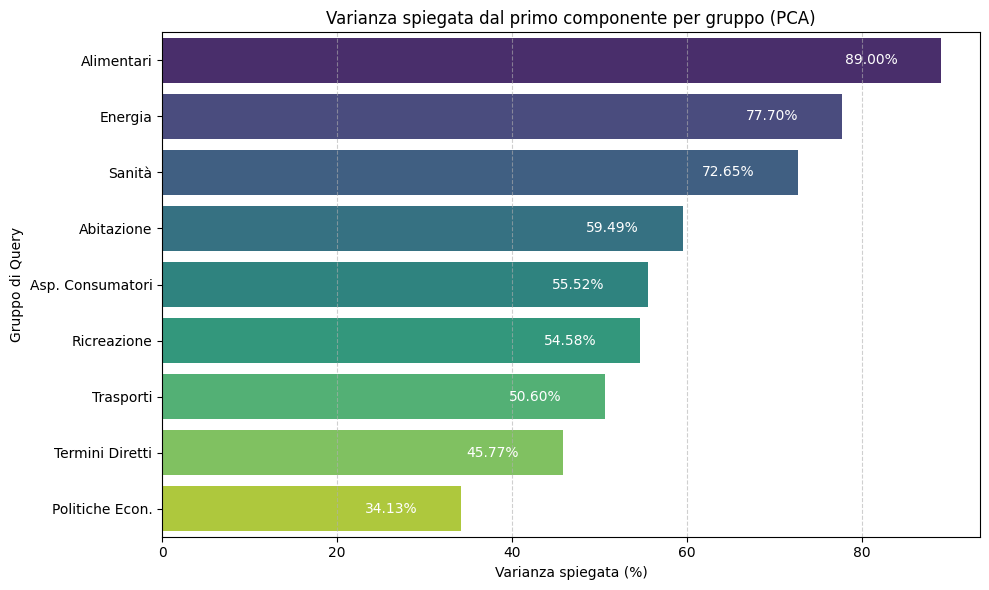

In [ ]:
# 9. Visualizzazione della varianza spiegata
import seaborn as sns

# Dati
gruppi = [
    "Alimentari", "Energia", "Sanità", "Abitazione", "Asp. Consumatori",
    "Ricreazione", "Trasporti", "Termini Diretti", "Politiche Econ."
]
varianza = [89.00, 77.70, 72.65, 59.49, 55.52, 54.58, 50.60, 45.77, 34.13]

# Plot
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=varianza, y=gruppi, palette="viridis")
plt.xlabel("Varianza spiegata (%)")
plt.ylabel("Gruppo di Query")
plt.title("Varianza spiegata dal primo componente per gruppo (PCA)")
plt.grid(axis='x', linestyle='--', alpha=0.6)

# Etichette all’interno delle barre
for i, (value, label) in enumerate(zip(varianza, gruppi)):
    ax.text(value - 5, i, f"{value:.2f}%", color="white", va='center', ha='right', fontsize=10)

plt.tight_layout()
plt.show()


#### Conclusioni intermedie

In questa prima versione dello script sono stati costruiti gli indici sintetici per ciascun gruppo tematico di query, nonché un indice globale aggregato. I risultati ottenuti suggeriscono una **buona capacità esplicativa** della componente principale per molti gruppi (in particolare "Alimentari", "Energia", "Sanità"), mentre altri presentano una varianza spiegata più contenuta, suggerendo la necessità di rivedere la coerenza interna del gruppo di query. I prossimi step prevedono una revisione metodologica dei gruppi meno performanti, con la possibilità di rimuovere, sostituire o aggiungere termini in modo giustificato, al fine di migliorare l'efficacia dei segnali estratti da Google Trends.

I dettagli delle modifiche e le giustificazioni per ciascuna query saranno documentati in **Appendice A**, così da mantenere il corpo principale del progetto sintetico e focalizzato sui risultati finali.